# setting

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
! pip install sentence_transformers datasets

In [27]:
# import

import random
import math
import numpy as np
import logging
from datetime import datetime
import pandas as pd
import os
import csv
from typing import List, Union
from tqdm.autonotebook import trange

import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader, random_split
from sentence_transformers import SentenceTransformer, models, LoggingHandler, losses, util, SentencesDataset
from sentence_transformers.evaluation import SentenceEvaluator, TripletEvaluator
from sentence_transformers.readers import InputExample
from sentence_transformers.datasets import NoDuplicatesDataLoader

# dataset

In [28]:
# wa3i 프로젝트 데이터
wa3i_data = pd.read_csv('/content/drive/MyDrive/종설/dataset/science_wai.csv', usecols=['sentence1', 'sentence2', 'gold_label'])
wa3i_data = wa3i_data.dropna(how='any')
wa3i_data

,sentence1,sentence2,gold_label
0,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자가 없으면 소비자가 먹을 것이 없어 죽게되고 분해자도 소비자가 다 죽어 소비자...,entailment
1,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자가 생태계에 없으면 소비자와 분해자가 먹을것을 못먹는다.못먹는 소비자와 분해자...,entailment
2,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자가 있지 않으면 생산자를 먹는 동물도 그 동물을 먹는 동물도 굶게 되어 생태계...,entailment
3,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자는 소비자와 분해자들에게 영양을 제공한다. 만약 생산자가 없다면 소비자는 영양...,entailment
4,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자가 없으면 소비자와 분해자는 독립영양을 못하기 때문에 죽게되기 때문이다,entailment
...,...,...,...
8721,부력에 의해 배를 띄울 수 있다.,물이 힘이있어서,contradiction
8722,부력에 의해 배를 띄울 수 있다.,파도를 이용하여 뜨게 하는것 같다,contradiction
8723,부력에 의해 배를 띄울 수 있다.,물체를 띄우는 힘인 부력을 활용한 것이다.,entailment
8724,부력에 의해 배를 띄울 수 있다.,배는 부력의 원리로 뜨기 때문에 물을 사용하면 쉽게 이동시킬 수 있다.,entailment


In [29]:
# 직접 수집한 데이터
custom_data = pd.read_csv('/content/drive/MyDrive/종설/dataset/science_workbook.csv', usecols=['sentence1', 'sentence2', 'gold_label'])
custom_data = custom_data.dropna(how='any')
custom_data

,sentence1,sentence2,gold_label
0,이온들이 단단히 규칙적으로 결합하고 있어 이동할 수 없으므로 전기 전도성이 없다.,이온들이 견고하게 배열돼 있어서 이동이 어려워 전기 전도성이 없습니다.,entailment
1,이온들이 단단히 규칙적으로 결합하고 있어 이동할 수 없으므로 전기 전도성이 없다.,이온들이 자유롭게 움직일 수 있으므로 전기 전도성이 있습니다.,contradiction
2,생성물의 에너지 합이 반응물의 에너지 합보다 작다.,반응물의 에너지 합이 생성물의 에너지 합보다 크지 않습니다,entailment
3,생성물의 에너지 합이 반응물의 에너지 합보다 작다.,생성물의 에너지 합이 반응물의 에너지 합보다 크다.,contradiction
4,주위의 온도가 높아진다.,주위의 온도가 상승합니다.,entailment
...,...,...,...
508,태풍의 중심이 가장 가까이 통과할 때 풍속이 거의 최대치에 이르고 있다. 따라서 관...,태풍의 중심이 관측 지역을 가장 가까이 통과할 때 풍속이 매우 약해진다,contradiction
509,태풍의 중심은 낮은 기압으로 인해 주변보다 해수면의 높이가 높게 나타난다. 이로 인...,태풍의 중심은 낮은 기압으로 인해 주변보다 해수면의 높이가 높아지는데 이로 인해 태...,entailment
510,태풍의 중심은 낮은 기압으로 인해 주변보다 해수면의 높이가 높게 나타난다. 이로 인...,태풍의 중심은 낮은 기압으로 인해 주변보다 해수면의 높이가 낮게 나타난다. 이로 인...,contradiction
511,온난 전선이 지날 때에는 차가운 공기의 영향을 받다가 따뜻한 공기의 영향을 받게 되...,온난 전선이 지나갈 때에는 따뜻한 공기의 영향을 받아 기온이 상승하고 한랭 전선이 ...,entailment


In [53]:
# transform to Triplet format

def make_nli_triplet_input_example(dataset):
    train_data = {}

    def add_to_samples(sent1, sent2, label):
        if sent1 not in train_data:
            train_data[sent1] = {'contradiction': set(), 'entailment': set(), 'neutral': set()}
        train_data[sent1][label].add(sent2)

    for i, row in dataset.iterrows():
        sent1 = str(row['sentence1']).strip()
        sent2 = str(row['sentence2']).strip()
        label = row['gold_label'].strip()

        add_to_samples(sent1, sent2, label)

    # transform to InputExamples
    input_examples = []
    for sent1, others in train_data.items():
        if len(others['entailment']) > 0 and len(others['contradiction']) > 0:
            entailment_list = list(others['entailment'])
            contradiction_list = list(others['contradiction'])

            # Shuffle the lists to randomize the selection
            random.shuffle(entailment_list)
            random.shuffle(contradiction_list)

            # Use the same anchor for multiple triplets
            anchor = sent1

            for _ in range(10):  # Adjust the number of triplets as needed
                ent = random.choice(entailment_list)
                con = random.choice(contradiction_list)

                input_examples.append(InputExample(texts=[anchor, ent, con]))

    return input_examples

In [54]:
wa3i_dataset = make_nli_triplet_input_example(wa3i_data)
wa3i_dataset[0].texts

['생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계의 소비자도 먹이가 없어서 죽게 되어 생태계의 균형이 깨진다.',
 '생산자가 먹을 것을 생산하지 못하면 차차차소비자도 줄어든다',
 '없으면 안되니까']

In [55]:
custom_dataset = make_nli_triplet_input_example(custom_data)
custom_dataset[0].texts

['이온들이 단단히 규칙적으로 결합하고 있어 이동할 수 없으므로 전기 전도성이 없다.',
 '이온들이 견고하게 배열돼 있어서 이동이 어려워 전기 전도성이 없습니다.',
 '이온들이 자유롭게 움직일 수 있으므로 전기 전도성이 있습니다.']

In [56]:
print(f'triplet wa3i: {len(wa3i_dataset)}')
print(f'triplet custom: {len(custom_dataset)}')

triplet wa3i: 1040
triplet custom: 2380


In [59]:
# (wa3i dataset) 8:2 split

dataset_size = len(wa3i_dataset)
wa3i_train_size = int(dataset_size * 0.8)
wa3i_validation_size = int(dataset_size * 0.2)
wa3i_test_size = dataset_size - wa3i_train_size - wa3i_validation_size

wa3i_train, wa3i_valid, wa3i_test = random_split(wa3i_dataset, [wa3i_train_size, wa3i_validation_size, wa3i_test_size])

print(f"Training Data Size : {len(wa3i_train)}")
print(f"Validation Data Size : {len(wa3i_valid)}")
print(f"Testing Data Size : {len(wa3i_test)}")

Training Data Size : 832
Validation Data Size : 208
Testing Data Size : 0


In [60]:
# (custom dataset) 8:2 split

dataset_size = len(custom_dataset)
custom_train_size = int(dataset_size * 0.8)
custom_validation_size = int(dataset_size * 0.2)
custom_test_size = dataset_size - custom_train_size - custom_validation_size

custom_train, custom_valid, custom_test = random_split(custom_dataset, [custom_train_size, custom_validation_size, custom_test_size])

print(f"Training Data Size : {len(custom_train)}")
print(f"Validation Data Size : {len(custom_valid)}")
print(f"Testing Data Size : {len(custom_test)}")

Training Data Size : 1904
Validation Data Size : 476
Testing Data Size : 0


In [61]:
# merge dataset

train_dataset = wa3i_train + custom_train
validation_dataset = wa3i_valid + custom_valid
test_dataset = wa3i_test + custom_test
print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

Training Data Size : 2736
Validation Data Size : 684
Testing Data Size : 0


# evaluator

In [62]:
# Evaluator by train
train_evaluator = TripletEvaluator.from_input_examples(
    train_dataset,
    name="train-evaluator",
)

# Evaluator by validation
valid_evaluator = TripletEvaluator.from_input_examples(
    validation_dataset,
    name="valid-evaluator",
)

# Evaluator by test
test_evaluator = TripletEvaluator.from_input_examples(
    test_dataset,
    name="test-evaluator",
)


In [63]:
# get loss value

logger = logging.getLogger(__name__)


class LossEvaluator(SentenceEvaluator):

    def __init__(self, loader, loss_model: nn.Module = None, name: str = '', log_dir: str = None,
                 show_progress_bar: bool = False, write_csv: bool = True):

        """
        Evaluate a model based on the loss function.
        The returned score is loss value.
        The results are written in a CSV and Tensorboard logs.
        :param loader: Data loader object
        :param loss_model: loss module object
        :param name: Name for the output
        :param log_dir: path for tensorboard logs
        :param show_progress_bar: If true, prints a progress bar
        :param write_csv: Write results to a CSV file
        """

        self.loader = loader
        self.write_csv = write_csv
        self.logs_writer = SummaryWriter(log_dir=log_dir)
        self.name = name
        self.loss_model = loss_model

        # move model to gpu:  lidija-jovanovska
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        loss_model.to(self.device)

        if show_progress_bar is None:
            show_progress_bar = (
                    logger.getEffectiveLevel() == logging.INFO or logger.getEffectiveLevel() == logging.DEBUG)
        self.show_progress_bar = show_progress_bar

        self.csv_file = "loss_evaluation" + ("_" + name if name else '') + "_results.csv"
        self.csv_headers = ["epoch", "steps", "loss"]

    def __call__(self, model, output_path: str = None, epoch: int = -1, steps: int = -1) -> float:

        self.loss_model.eval()

        loss_value = 0
        self.loader.collate_fn = model.smart_batching_collate
        num_batches = len(self.loader)
        data_iterator = iter(self.loader)

        with torch.no_grad():
          for _ in trange(num_batches, desc="Iteration", smoothing=0.05, disable=not self.show_progress_bar):
              sentence_features, labels = next(data_iterator)
              # move data to gpu
              for i in range(0, len(sentence_features)):
                  for key, value in sentence_features[i].items():
                      sentence_features[i][key] = sentence_features[i][key].to(self.device)
              labels = labels.to(self.device)
              loss_value += self.loss_model(sentence_features, labels).item()

        final_loss = loss_value / num_batches
        if output_path is not None and self.write_csv:

            csv_path = os.path.join(output_path, self.csv_file)
            output_file_exists = os.path.isfile(csv_path)

            with open(csv_path, newline='', mode="a" if output_file_exists else 'w', encoding="utf-8") as f:
                writer = csv.writer(f)
                if not output_file_exists:
                    writer.writerow(self.csv_headers)

                writer.writerow([epoch, steps, final_loss])

            # ...log the running loss
            self.logs_writer.add_scalar('val_loss',
                                        final_loss,
                                        steps)

        self.loss_model.zero_grad()
        self.loss_model.train()

        return final_loss

# model

In [64]:
# Load Embedding Model
embedding_model = models.Transformer(
    model_name_or_path="BM-K/KoSimCSE-roberta-multitask",
    max_seq_length=869,
    do_lower_case=True
)

# Only use Mean Pooling -> Pooling all token embedding vectors of sentence.
pooling_model = models.Pooling(
    embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False,
)

model = SentenceTransformer(modules=[embedding_model, pooling_model])


In [65]:
# config
num_epochs = 20
batch_size = 16

In [66]:
train_dataset = SentencesDataset(train_dataset, model=model)

# Train / Valid Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [67]:
# train model
pretrained_model_name = "KoSimCSE-roberta"
model_save_path = 'output/' + pretrained_model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Use ContrastiveLoss
loss_func = losses.TripletLoss(model)

# warmup steps
warmup_steps = math.ceil(len(train_dataset) * num_epochs / batch_size * 0.5) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

epochs = []
train_list = []
valid_list = []
test_list = []
train_loss_history = []
valid_loss_history = []

# loss evaluator
train_loss_evaluator = LossEvaluator(train_dataloader, loss_model=loss_func, log_dir='logs/', name='train')
valid_loss_evaluator = LossEvaluator(valid_dataloader, loss_model=loss_func, log_dir='logs/', name='valid')

# Training
for epoch in range(num_epochs):
    print(f'{epoch} epoch')
    epochs.append(epoch)
    model.fit(
              train_objectives=[(train_dataloader, loss_func)],
              evaluator=valid_evaluator,
              epochs=1,
              evaluation_steps=int(len(train_dataloader)*0.1),
              warmup_steps=warmup_steps,
              output_path=model_save_path,
              use_amp=False      #Set to True, if your GPU supports FP16 operations
    )

    train = train_evaluator(model)
    train_list.append(train)
    print(f'train => {train}')

    valid = valid_evaluator(model)
    valid_list.append(valid)
    print(f'valid => {valid}')

    # todo: test 데이터 사용 시 주석 해제
    # test = test_evaluator(model)
    # test_list.append(test)
    # print(f'test => {test}')

    train_loss = train_loss_evaluator(model)
    train_loss_history.append(train_loss)
    print(f'train_loss => {train_loss}')

    valid_loss = valid_loss_evaluator(model)
    valid_loss_history.append(valid_loss)
    print(f'valid_loss => {valid_loss}')

0 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/171 [00:00<?, ?it/s]

train => 0.9466374269005848
valid => 0.9312865497076024
train_loss => 0.9450086541691719
valid_loss => 1.024887669918149
1 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/171 [00:00<?, ?it/s]

train => 0.9641812865497076
valid => 0.9532163742690059
train_loss => 0.7010921116983682
valid_loss => 0.775613475677579
2 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/171 [00:00<?, ?it/s]

train => 0.9692982456140351
valid => 0.9707602339181286
train_loss => 0.5382090493252403
valid_loss => 0.6169581489507542
3 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/171 [00:00<?, ?it/s]

train => 0.9788011695906432
valid => 0.9766081871345029
train_loss => 0.4101599437451502
valid_loss => 0.493523741184279
4 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/171 [00:00<?, ?it/s]

train => 0.9846491228070176
valid => 0.9809941520467836
train_loss => 0.32698533444376715
valid_loss => 0.40872055500052695
5 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/171 [00:00<?, ?it/s]

train => 0.9890350877192983
valid => 0.9883040935672515
train_loss => 0.25619104373873325
valid_loss => 0.33516834641611853
6 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/171 [00:00<?, ?it/s]

train => 0.9919590643274854
valid => 0.9926900584795322
train_loss => 0.20073915416734261
valid_loss => 0.29069717505643533
7 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/171 [00:00<?, ?it/s]

train => 0.9937865497076024
valid => 0.9926900584795322
train_loss => 0.15773957331626737
valid_loss => 0.24411607447058656
8 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/171 [00:00<?, ?it/s]

train => 0.9948830409356725
valid => 0.9941520467836257
train_loss => 0.1257633021351887
valid_loss => 0.21421983283619547
9 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/171 [00:00<?, ?it/s]

train => 0.9956140350877193
valid => 0.9941520467836257
train_loss => 0.09113647366127772
valid_loss => 0.1828354191641475
10 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/171 [00:00<?, ?it/s]

train => 0.9963450292397661
valid => 0.9941520467836257
train_loss => 0.0734291915830813
valid_loss => 0.1601246065178583
11 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/171 [00:00<?, ?it/s]

train => 0.9967105263157895
valid => 0.9941520467836257
train_loss => 0.05405073321005057
valid_loss => 0.13180681439333183
12 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/171 [00:00<?, ?it/s]

train => 0.9978070175438597
valid => 0.9956140350877193
train_loss => 0.0386173547359935
valid_loss => 0.11584708995597306
13 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/171 [00:00<?, ?it/s]

train => 0.9978070175438597
valid => 0.9956140350877193
train_loss => 0.029624755793844746
valid_loss => 0.10840821751328401
14 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/171 [00:00<?, ?it/s]

train => 0.9989035087719298
valid => 0.9970760233918129
train_loss => 0.02287744830923471
valid_loss => 0.10387275939763979
15 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/171 [00:00<?, ?it/s]

train => 0.9992690058479532
valid => 0.9970760233918129
train_loss => 0.0178558115373578
valid_loss => 0.09806346165579419
16 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/171 [00:00<?, ?it/s]

train => 0.9985380116959064
valid => 0.9956140350877193
train_loss => 0.017585747074662594
valid_loss => 0.10168319732643837
17 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/171 [00:00<?, ?it/s]

train => 1.0
valid => 0.9985380116959064
train_loss => 0.009080325476607384
valid_loss => 0.09268838609027308
18 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/171 [00:00<?, ?it/s]

train => 0.9989035087719298
valid => 0.9970760233918129
train_loss => 0.015091251385839362
valid_loss => 0.09784086984257366
19 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/171 [00:00<?, ?it/s]

train => 0.9989035087719298
valid => 0.9970760233918129
train_loss => 0.013442448705260516
valid_loss => 0.09871913644290248


# result

In [68]:
# evaluation valid
valid_evaluator(model, output_path=model_save_path)

0.9970760233918129

In [69]:
# todo: test 데이터 사용 시 주석 해제
# evaluation test
# test_evaluator(model, output_path=model_save_path)

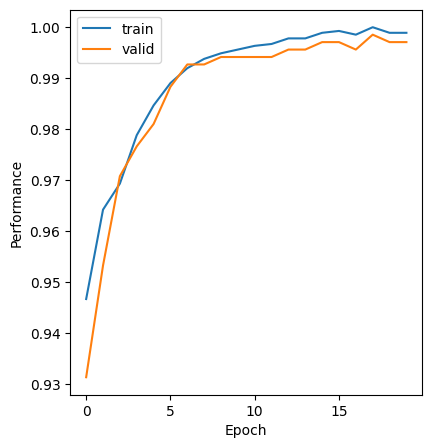

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.plot(epochs, train_list, label='train')
plt.plot(epochs, valid_list, label='valid')
plt.legend()
plt.show()

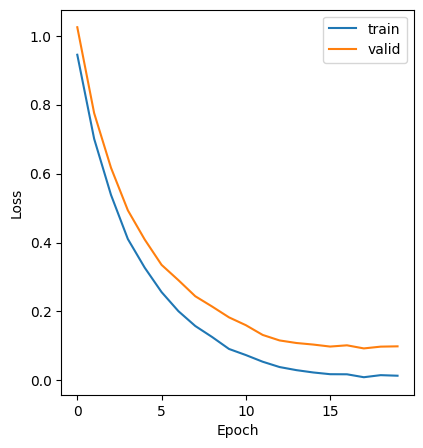

In [71]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epochs, train_loss_history, label='train')
plt.plot(epochs, valid_loss_history, label='valid')
plt.legend()
plt.show()

In [72]:
# 문장을 정의
sentence1 = "주위의 온도가 높아진다."
sentence2 = "온도는 상승한다."

# 두 문장을 모델로 임베딩
embeddings = model.encode([sentence1, sentence2], convert_to_tensor=True)

# 코사인 유사도 계산
cosine_score = util.pytorch_cos_sim(embeddings[0], embeddings[1])

print(f"첫 번째 문장과 두 번째 문장의 코사인 유사도: {cosine_score.item():.4f}")

첫 번째 문장과 두 번째 문장의 코사인 유사도: 0.9267


In [73]:
# 문장을 정의
sentence1 = "주위의 온도가 높아진다."
sentence2 = "온도는 상승하지 않는다."

# 두 문장을 모델로 임베딩
embeddings = model.encode([sentence1, sentence2], convert_to_tensor=True)

# 코사인 유사도 계산
cosine_score = util.pytorch_cos_sim(embeddings[0], embeddings[1])

print(f"첫 번째 문장과 두 번째 문장의 코사인 유사도: {cosine_score.item():.4f}")

첫 번째 문장과 두 번째 문장의 코사인 유사도: 0.1049
